## Дерево решений (CART algorithm)



В данном примере примере рассмотрим алгоритм дерева решений для задач классификации. 

     В качестве алгоритма используем алгоритм CART, т.к. он наиболее гибкий, может решать задачи как регрессии, так и классификации.
Данный алгоритм разбивает данные и по категориальным признакам и по непрерывным. В процессе роста дерева алгоритм CART проводит для каждого узла полный перебор всех атрибутов, на основе которых может быть построено разбиение, и выбирает тот, который максимизирует значение *Прироста информации*

 - Для задач классификации в качестве *критерия информативности* обычно используется критерий Джинни 

 - Для задач регрессии можно в качестве *критерия информативности* использовать MSE, MAE 

Основная идея алгоритма заключается в том, чтобы выбрать такое разбиение из всех возможных в данном узле, чтобы полученные дочерние узлы были максимально однородными. При этом каждое разбиение производится только по одному атрибуту.

Алгоритм CART предназначен для построения бинарного дерева решений. Бинарные (двоичные) деревья — деревья, каждый узел которых при разбиении имеет только двух потомков.

### Немного о идее предсказания непрерывной величины (Дерево решений для задач регрессии)
- 1) Создается корневой узел
- 2) выбирается первый признак, по которому будет идти разбиение объектов.
- 3) у данного признака выбираются все возможные "Пороговые значения", по которым будут разбиваться данные
- 4) При каждом потенциальном разбиении рассчитывается прирост информации.

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

_Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.
 
 - 5) Находим "лучшее" пороговое значение и признак, которые обеспечивают максимум прироста инфромации. 
 - 6) Разбиваем наш узел на два потомка (Алгоритм CART является бинарным и создает двоичное дерево, узел делится на два потомка)
 - 7) Когда доходим до листа (Создать лист можно разными путями, о критериях останова поговорим позже), в качестве предсказания в листе берем среднее по объектам в листе целевой переменной (Задача регрессии)

### Критерии останова:
- 1) Минимальное количество объектов в листе (избавляемся от переобучения)
- 2) Глубина дерева
- 3) Прирост информации равен нулю или совсем незначительный
- 4) Количество листьев

### Реализация

- Для работы с данным я использую две библиотеки, это numpy и pandas

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

- Реализация функции рассчитывающей Джинни

In [2]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

- Функция рассчитывающая прирост информации

In [3]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

- Функция разбиения объектов узла на две выборки

In [4]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

- Функция, которая находит наилучшее разбиение

In [5]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [6]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [9]:
from sklearn.datasets import make_classification # С помощью данной библиотеки создаем рандомный датасет 
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
import matplotlib.pyplot as plt

In [10]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

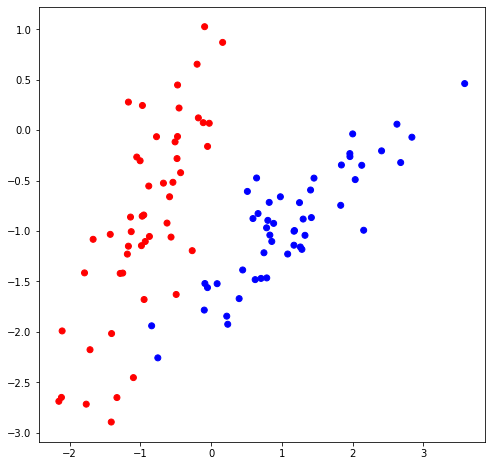

In [11]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [12]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [13]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [15]:
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.09712237000978252
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [25]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [26]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [27]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [28]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [29]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [30]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [31]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

### Визуализируем наши ответы

In [32]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

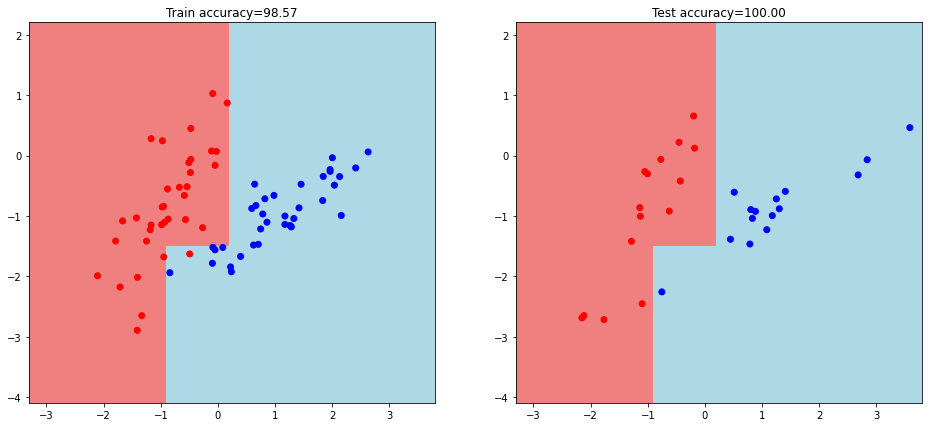

In [33]:
visualize(train_data, test_data)

## Вывод: Дерево неплохо справилось с задачей классификации. На обучающей выборке доля правильных ответов 0.98, на тестовой 1. 